# 4. Analizu podataka i vizualizaciju

### Imports + putanja do baze

- Path (za putanje),
- sqlite3 (spajanje na SQLite),
- pandas (rad s tablicama),
- matplotlib.pyplot (grafovi).

In [ ]:
from pathlib import Path
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Postavljanje putanja do podataka
PROJECT_ROOT = Path.cwd().parent  # notebooks/ -> project root
DB_PATH = PROJECT_ROOT / "data_processed" / "pap.db"
DB_PATH.exists(), DB_PATH

# Učitavanje podataka iz SQLite baze podataka
TW_CSV = DATA_RAW / "Time-Wasters on Social Media.csv"
assert TW_CSV.exists(), f"Ne postoji: {TW_CSV}"

tw_raw = pd.read_csv(TW_CSV)

print("TW loaded:", tw_raw.shape)
display(tw_raw.head())

TW loaded: (1000, 31)


,UserID,Age,Gender,Location,Income,Debt,Owns Property,Profession,Demographics,Platform,...,ProductivityLoss,Satisfaction,Watch Reason,DeviceType,OS,Watch Time,Self Control,Addiction Level,CurrentActivity,ConnectionType
0,1,56,Male,Pakistan,82812,True,True,Engineer,Rural,Instagram,...,3,7,Procrastination,Smartphone,Android,9:00 PM,5,5,Commuting,Mobile Data
1,2,46,Female,Mexico,27999,False,True,Artist,Urban,Instagram,...,5,5,Habit,Computer,Android,5:00 PM,7,3,At school,Wi-Fi
2,3,32,Female,United States,42436,False,True,Engineer,Rural,Facebook,...,6,4,Entertainment,Tablet,Android,2:00 PM,8,2,At home,Mobile Data
3,4,60,Male,Barzil,62963,True,False,Waiting staff,Rural,YouTube,...,3,7,Habit,Smartphone,Android,9:00 PM,5,5,Commuting,Mobile Data
4,5,25,Male,Pakistan,22096,False,True,Manager,Urban,TikTok,...,8,2,Boredom,Smartphone,iOS,8:00 AM,10,0,At home,Mobile Data


### Helper za čitanje tablica

Učitavmo tablice iz 03_database.ipynb

In [ ]:
def read_table(name: str) -> pd.DataFrame:
    conn = sqlite3.connect(DB_PATH)
    try:
        return pd.read_sql_query(f"SELECT * FROM {name};", conn)
    finally:
        conn.close()
        
# Učitavanje tablica iz baze podataka
dt_yearly = read_table("dt_yearly")
wb_year = read_table("wb_internet_year")
ind = read_table("integrated_individual")

dt_yearly.head(), wb_year.head(), ind.head()


(   Year  daily_minutes  internet_pct
 0  2012             90     38.020353
 1  2013             95     40.499988
 2  2014            104     43.315020
 3  2015            111     46.123280
 4  2016            128     49.483999,
    Year  internet_pct
 0  1960           NaN
 1  1961           NaN
 2  1962           NaN
 3  1963           NaN
 4  1964           NaN,
    age  gender    job_type  daily_social_media_time  number_of_notifications  \
 0   56    Male  Unemployed                 4.180940                       61   
 1   46    Male      Health                 3.249603                       59   
 2   56  Female  Unemployed                 4.381070                       60   
 3   36  Female   Education                 4.089168                       49   
 4   40  Female   Education                 4.097401                       57   
 
    work_hours_per_day  perceived_productivity_score  \
 0            6.753558                      8.040464   
 1            9.169296          

### Brzi pregled podataka

In [63]:
def quick_overview(df: pd.DataFrame, name: str):
    print(f"=== {name} ===")
    print("shape:", df.shape)
    print("missing ratio (top 10):")
    miss = (df.isna().mean().sort_values(ascending=False) * 100).head(10)
    display(miss.to_frame("missing_%"))
    print()

quick_overview(dt_yearly, "dt_yearly")
quick_overview(wb_year, "wb_internet_year")
quick_overview(ind, "integrated_individual")


=== dt_yearly ===
shape: (13, 3)
missing ratio (top 10):


,missing_%
Year,0.0
daily_minutes,0.0
internet_pct,0.0



=== wb_internet_year ===
shape: (65, 2)
missing ratio (top 10):


,missing_%
internet_pct,46.153846
Year,0.000000



=== integrated_individual ===
shape: (23730, 15)
missing ratio (top 10):


,missing_%
stress_level,6.316898
gender,0.000000
age,0.000000
daily_social_media_time,0.000000
number_of_notifications,0.000000
work_hours_per_day,0.000000
job_type,0.000000
perceived_productivity_score,0.000000
actual_productivity_score,0.000000
social_platform_preference,0.000000


## DT trend po godinama

Sortiraš dt_yearly po Year.
- x = Year
- y = daily_minutes

Svaka točka predstavlja prosjek za jednu godinu.
Linija pokazuje promjenu trenda: raste / pada / stagnira
Linijski graf prikazuje prosječno dnevno vrijeme provedeno na internetu (u minutama) kroz godine iz DT skupa 

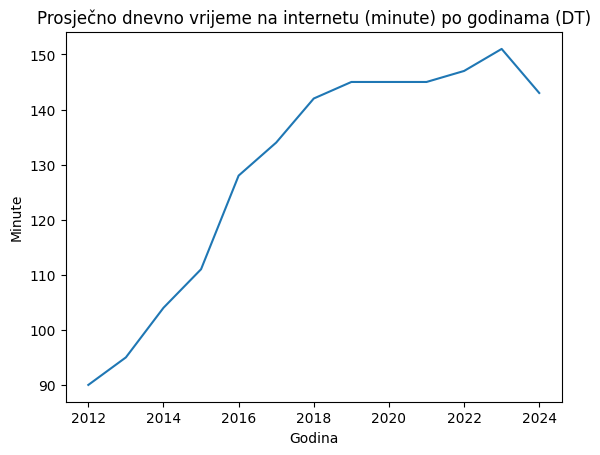

In [64]:
dt_yearly = dt_yearly.sort_values("Year")
plt.figure()
plt.plot(dt_yearly["Year"], dt_yearly["daily_minutes"])
plt.title("Prosječno dnevno vrijeme na internetu (minute) po godinama (DT)")
plt.xlabel("Godina")
plt.ylabel("Minute")
plt.show()


##  WorldBank trend (internet_pct)

Linijski graf prikazuje udio populacije koja koristi internet (%) po godinama, iz World Bank izvora (wb_internet_year).

Vidljiv je kontinuirani rast postotka korisnika interneta kroz desetljeća.

Rast je često brži u kasnijim godinama (širenje infrastrukture, mobilni internet).


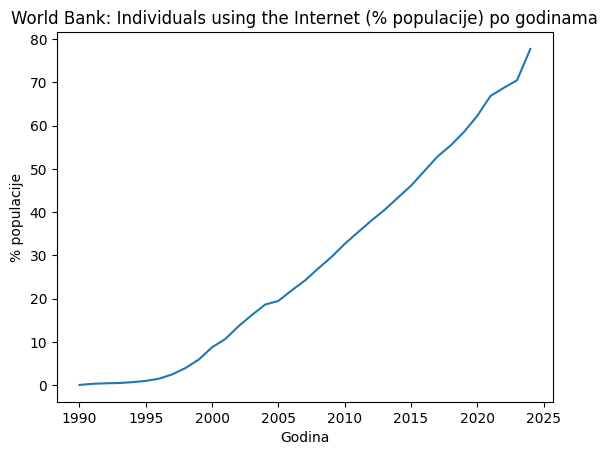

In [65]:
wb_year = wb_year.sort_values("Year")
plt.figure()
plt.plot(wb_year["Year"], wb_year["internet_pct"])
plt.title("World Bank: Individuals using the Internet (% populacije) po godinama")
plt.xlabel("Godina")
plt.ylabel("% populacije")
plt.show()


## Join DT + WB po godini + graf + korelacija

- daily_minutes (koliko se koristi internet u minutama)
- internet_pct (koliki postotak ljudi ima/koristi internet)

Korelacija (Pearson) ide od -1 do +1.
- +1: jači internet% → više minuta (savršeno pozitivno)
- 0: nema linearnog odnosa
- -1: jači internet% → manje minuta (negativno)

Columns: ['Year', 'daily_minutes', 'internet_pct']


,Year,daily_minutes,internet_pct
0,2012,90,38.020353
1,2013,95,40.499988
2,2014,104,43.315020
3,2015,111,46.123280
4,2016,128,49.483999
5,2017,134,52.872149
6,2018,142,55.449201
7,2019,145,58.575574
8,2020,145,62.294095
9,2021,145,66.899287


Missing internet_pct: 0.0
Korelacija daily_minutes vs internet_pct: 0.8855538469368354


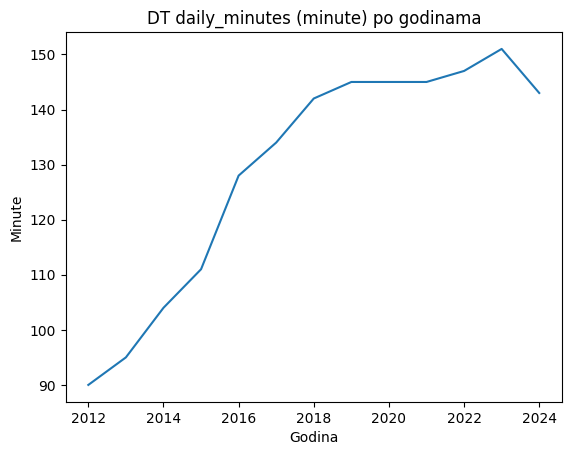

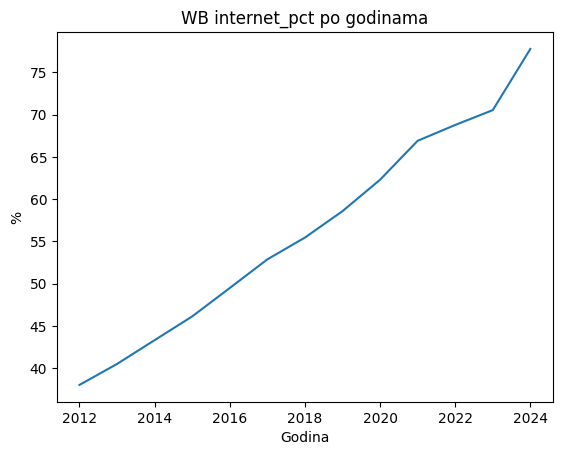

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


dt_tmp = dt_yearly.copy()
wb_tmp = wb_year.copy()


if "internet_pct" not in wb_tmp.columns:
    if "value" in wb_tmp.columns:
        wb_tmp = wb_tmp.rename(columns={"value": "internet_pct"})
    else:
        raise KeyError(
            "Ne mogu naći stupac za postotak interneta. "
            f"wb_year columns={wb_tmp.columns.tolist()}"
        )

# UZMI
#    - iz DT uzmi samo Year i daily_minutes
#    - iz WB uzmi Year i internet_pct
dt_tmp = dt_tmp[["Year", "daily_minutes"]].copy()
wb_tmp = wb_tmp[["Year", "internet_pct"]].copy()

# 3)Normalizacija Year na Int64 
dt_tmp["Year"] = pd.to_numeric(dt_tmp["Year"], errors="coerce").astype("Int64")
wb_tmp["Year"] = pd.to_numeric(wb_tmp["Year"], errors="coerce").astype("Int64")


dt_tmp = dt_tmp.dropna(subset=["Year"])
wb_tmp = wb_tmp.dropna(subset=["Year"])


merged = (
    dt_tmp.merge(wb_tmp, on="Year", how="left")
          .sort_values("Year")
          .reset_index(drop=True)
)

print("Columns:", merged.columns.tolist())
display(merged.head(10))

#  korelacija 
missing_rate = merged["internet_pct"].isna().mean()
print("Missing internet_pct:", missing_rate)

corr_df = merged[["daily_minutes", "internet_pct"]].dropna()
corr = corr_df.corr(numeric_only=True).iloc[0, 1] if len(corr_df) > 1 else None
print("Korelacija daily_minutes vs internet_pct:", corr)

#  Grafovi

plt.figure()
plt.plot(merged["Year"], merged["daily_minutes"])
plt.title("DT daily_minutes (minute) po godinama")
plt.xlabel("Godina")
plt.ylabel("Minute")
plt.show()

plt.figure()
plt.plot(merged["Year"], merged["internet_pct"])
plt.title("WB internet_pct po godinama")
plt.xlabel("Godina")
plt.ylabel("%")
plt.show()


## Social media vs productivity 

Boxplot uspoređuje produktvnost između dvije skupine korisnika:
- LOW: korisnici u donjih 20% po daily_social_media_time
- HIGH: korisnici u gornjih 20% po daily_social_media_time
(“ekstremi” – namjerno izbacuješ sredinu da razlika bude jasnija)
- y-os: actual_productivity_score

Ako je HIGH grupa niže: veće korištenje društvenih mreža povezano s nižom produktivnošću.

Ako razlika nije velika ili se preklapa:
- produktivnost ovisi o drugim faktorima (stres, posao, broj sati rada, notifikacije).


C:\Users\david\AppData\Local\Temp\ipykernel_17952\2142007985.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([low_vals, high_vals], labels=["LOW (bottom 20%)", "HIGH (top 20%)"], showmeans=True)


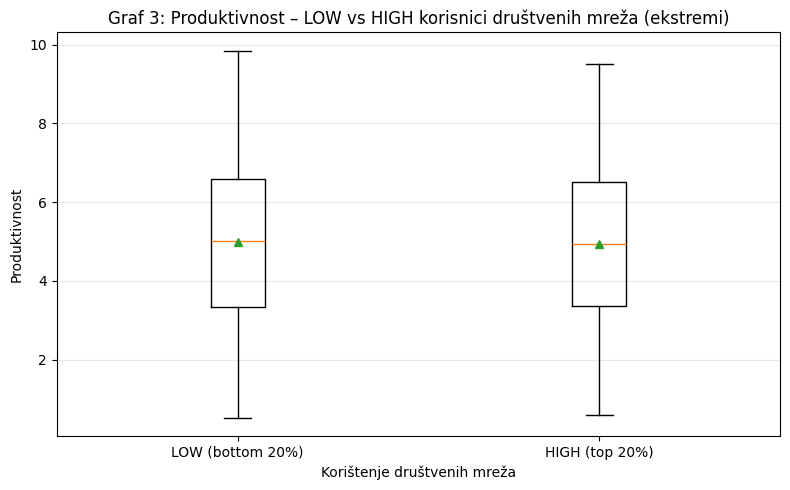

LOW prag (<=): 1.304 | HIGH prag (>=): 4.705
Medijan LOW: 5.008 | Medijan HIGH: 4.928 | Razlika: -0.081
Prosjek LOW: 4.977 | Prosjek HIGH: 4.929 | Razlika: -0.048
N LOW=4746 | N HIGH=4746


In [67]:
import numpy as np
import matplotlib.pyplot as plt

xcol = "daily_social_media_time"
ycol = "actual_productivity_score"

df = ind[[xcol, ycol]].dropna().copy()

p = 0.20  

low_thr  = df[xcol].quantile(p)
high_thr = df[xcol].quantile(1 - p)

df["group"] = np.where(df[xcol] <= low_thr, "LOW",
                np.where(df[xcol] >= high_thr, "HIGH", "MID"))

ext = df[df["group"] != "MID"].copy()

low_vals  = ext[ext["group"] == "LOW"][ycol].values
high_vals = ext[ext["group"] == "HIGH"][ycol].values

if len(low_vals) == 0 or len(high_vals) == 0:
    raise ValueError("LOW ili HIGH grupa je prazna. Probaj p=0.25 ili provjeri podatke.")

plt.figure(figsize=(8,5))
plt.boxplot([low_vals, high_vals], labels=["LOW (bottom 20%)", "HIGH (top 20%)"], showmeans=True)
plt.xlabel("Korištenje društvenih mreža")
plt.ylabel("Produktivnost")
plt.title("Graf 3: Produktivnost – LOW vs HIGH korisnici društvenih mreža (ekstremi)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

print(f"LOW prag (<=): {low_thr:.3f} | HIGH prag (>=): {high_thr:.3f}")
print(f"Medijan LOW: {np.median(low_vals):.3f} | Medijan HIGH: {np.median(high_vals):.3f} | Razlika: {(np.median(high_vals)-np.median(low_vals)):.3f}")
print(f"Prosjek LOW: {low_vals.mean():.3f} | Prosjek HIGH: {high_vals.mean():.3f} | Razlika: {(high_vals.mean()-low_vals.mean()):.3f}")
print(f"N LOW={len(low_vals)} | N HIGH={len(high_vals)}")


## Time-Wasters on Social Media

U ovom grafu grupiramo TW podatke prema stupcu CurrentActivity (gdje se korisnik nalazi / što radi dok koristi društvene mreže), te računamo:

- mean: prosječno vrijeme provedeno (Total Time Spent) u toj kategoriji
- count: broj zapisa u kategoriji

Zatim uzimamo top kategorije i prikazujemo prosjek kao stupčasti graf.

Stupci u tablici:


0                       UserID
1                          Age
2                       Gender
3                     Location
4                       Income
5                         Debt
6                Owns Property
7                   Profession
8                 Demographics
9                     Platform
10            Total Time Spent
11          Number of Sessions
12                    Video ID
13              Video Category
14                Video Length
15                  Engagement
16            Importance Score
17         Time Spent On Video
18    Number of Videos Watched
19                 Scroll Rate
20                   Frequency
21            ProductivityLoss
22                Satisfaction
23                Watch Reason
24                  DeviceType
25                          OS
26                  Watch Time
27                Self Control
28             Addiction Level
29             CurrentActivity
30              ConnectionType
dtype: object

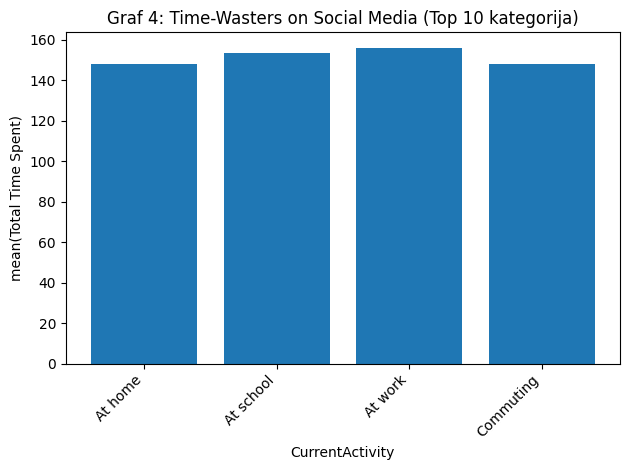

,CurrentActivity,mean,count
0,At home,148.097113,381
1,At school,153.590406,271
2,At work,155.918803,234
3,Commuting,148.008772,114


In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


tw = tw_raw.copy()

print("Stupci u tablici:")
display(pd.Series(tw.columns))

def pick_col(cols, keywords):
    cols_low = [c.lower() for c in cols]
    for kw in keywords:
        for c, cl in zip(cols, cols_low):
            if kw in cl:
                return c
    return None

cat_col = pick_col(tw.columns, ["waster", "waste", "activity", "purpose", "reason", "platform", "app", "category"])
num_col = pick_col(tw.columns, ["time", "minutes", "hours", "spent", "daily", "duration"])

if cat_col is None:
    obj_cols = tw.select_dtypes(include=["object"]).columns.tolist()
    cat_col = obj_cols[0] if obj_cols else None

if num_col is None:
    num_cols = tw.select_dtypes(include=[np.number]).columns.tolist()
    num_col = num_cols[0] if num_cols else None

if cat_col is None or num_col is None:
    raise ValueError(f"Ne mogu naći prikladne stupce. cat_col={cat_col}, num_col={num_col}")

df4 = tw[[cat_col, num_col]].dropna().copy()

g4 = (df4.groupby(cat_col)[num_col]
      .agg(mean="mean", count="count")
      .sort_values(["count", "mean"], ascending=[False, False])
      .head(10)
      .reset_index())


plt.figure()
plt.bar(g4[cat_col].astype(str), g4["mean"])
plt.xticks(rotation=45, ha="right")
plt.xlabel(cat_col)
plt.ylabel(f"mean({num_col})")
plt.title("Graf 4: Time-Wasters on Social Media (Top 10 kategorija)")
plt.tight_layout()
plt.show()

display(g4)


Rezultati prikazuju da je prosječno “waste” vrijeme na društvenim mrežama relativno stabilno kroz različite situacije, ali je  veće tijekom aktivnosti vezanih uz školu i posao.